In [17]:
import re
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [34]:

#folder_path = r'H:\api_data\TCS_1hr'
folder_path = r'H:\fno\anomaly_models\hourly\hul'

# Function to extract the batch number from file names
def extract_batch_number(filename):
    match = re.search(r'batch_(\d+)', filename)
    return int(match.group(1)) if match else float('inf')

# Get a list of all Excel files in the folder, sorted by batch number
excel_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.xlsx') or f.endswith('.xls')], key=extract_batch_number)

# Initialize an empty list to store dataframes
dfs = []

# Loop through each Excel file, read it, and append the dataframe to the list
for file in excel_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_excel(file_path)
    # Ensure DateTime is parsed consistently across files
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
    dfs.append(df)

# Concatenate all dataframes into one
combined_df = pd.concat(dfs)

# Ensure 'DateTime' column is in datetime format and sort by it in ascending order (oldest to newest)
combined_df = combined_df.sort_values(by='DateTime', ascending=True)

# Reset the index after sorting
combined_df.reset_index(drop=True, inplace=True)

In [35]:
import pandas as pd
import numpy as np

# --- Step 1: Convert and set datetime index ---
combined_df['DateTime'] = pd.to_datetime(combined_df['DateTime'])
combined_df.set_index('DateTime', inplace=True)

# --- Step 2: Add Moving Averages ---
combined_df['MA_20'] = combined_df['Close'].rolling(window=20).mean()
combined_df['MA_50'] = combined_df['Close'].rolling(window=50).mean()

# --- Step 3: Add RSI ---
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

combined_df['RSI_14'] = compute_rsi(combined_df['Close'])

# --- Step 4: Add Lag Features (for Close and Volume) ---
for lag in range(1, 4):  # 1 to 3
    combined_df[f'Close_Lag_{lag}'] = combined_df['Close'].shift(lag)
    combined_df[f'Volume_Lag_{lag}'] = combined_df['Volume'].shift(lag)

# --- Step 5: Drop rows with NaNs (due to rolling and lagging) ---
combined_df.dropna(inplace=True)

# --- Optional: Reset index if needed ---
# combined_df.reset_index(inplace=True)

# Show preview
print(combined_df.head())


                       Open    High    Low   Close  Volume     MA_20    MA_50  \
DateTime                                                                        
2016-10-14 09:15:00  854.75  855.55  840.1  842.15  439071  871.8475  871.879   
2016-10-14 10:15:00  842.10  842.90  837.0  841.50  381762  870.1900  871.316   
2016-10-14 11:15:00  841.50  844.80  840.8  844.50  177397  868.8725  870.826   
2016-10-14 12:15:00  844.50  850.70  844.1  848.10  331602  867.3400  870.458   
2016-10-14 13:15:00  848.15  848.40  842.4  844.05  255537  865.6825  870.040   

                        RSI_14  Close_Lag_1  Volume_Lag_1  Close_Lag_2  \
DateTime                                                                 
2016-10-14 09:15:00  20.015221       862.05      190164.0       863.00   
2016-10-14 10:15:00  18.027735       842.15      439071.0       862.05   
2016-10-14 11:15:00  22.408537       841.50      381762.0       842.15   
2016-10-14 12:15:00  22.878788       844.50      177397.0     

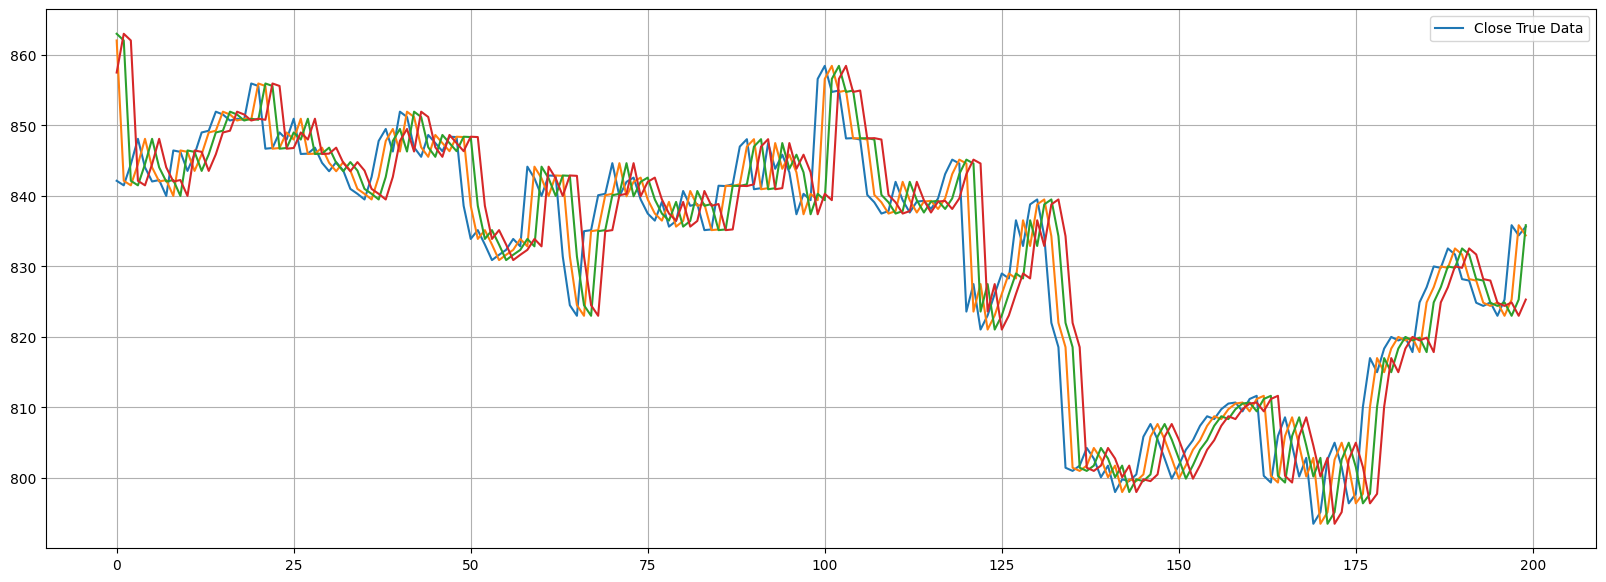

In [42]:
pts = 200
plt.figure(figsize=(20, 7))
plt.plot(np.array(combined_df['Close'][:pts]), label = 'Close True Data')
plt.plot(np.array(combined_df['Close_Lag_1'][:pts]))
plt.plot(np.array(combined_df['Close_Lag_2'][:pts]))
plt.plot(np.array(combined_df['Close_Lag_3'][:pts]))
plt.legend()
plt.grid()
plt.show()

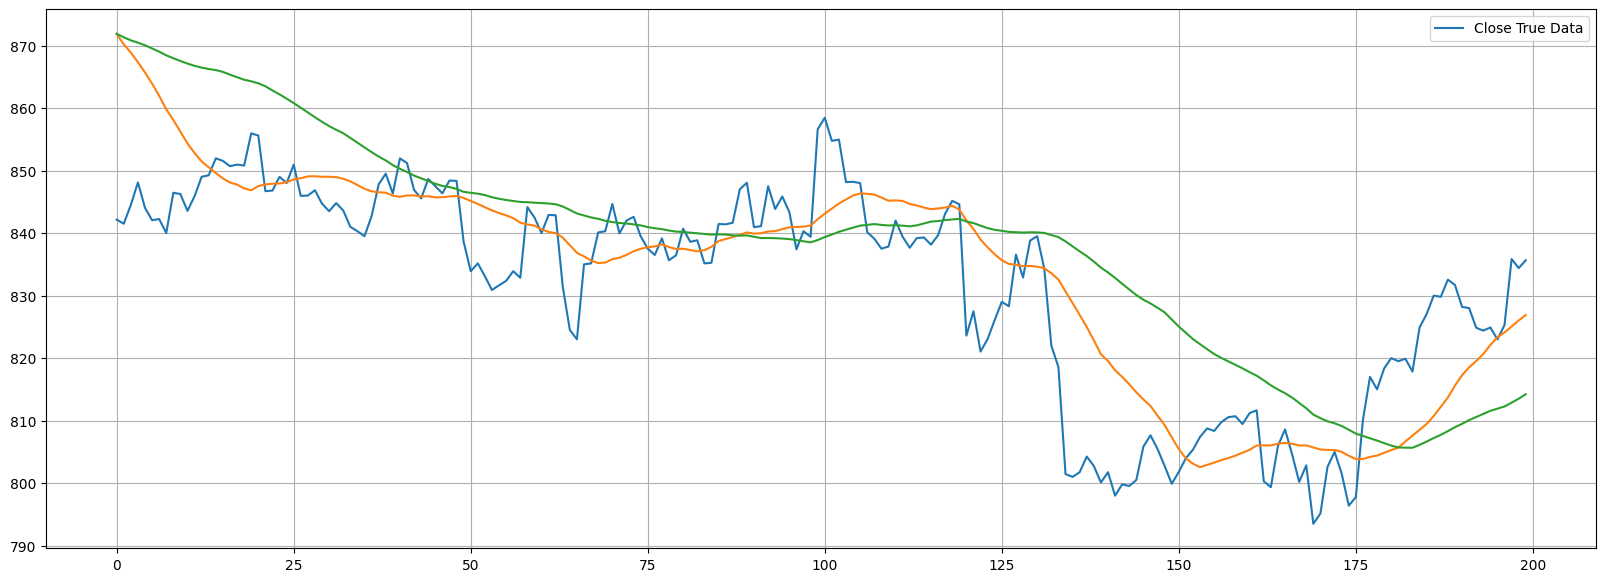

In [43]:
pts = 200
plt.figure(figsize=(20, 7))
plt.plot(np.array(combined_df['Close'][:pts]), label = 'Close True Data')
plt.plot(np.array(combined_df['MA_20'][:pts]))
plt.plot(np.array(combined_df['MA_50'][:pts]))
plt.legend()
plt.grid()
plt.show()

In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model

# --- Step 1: Define the window length and input columns ---
window_length = 7
ohlcv_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# --- Step 2: Prepare sequences ---
def create_ohlcv_sequences(df, cols, window):
    data = df[cols].values
    sequences = []
    for i in range(len(data) - window + 1):
        sequences.append(data[i:i + window])
    return np.array(sequences)

ohlcv_sequences = create_ohlcv_sequences(combined_df, ohlcv_cols, window_length)

# --- Step 3: Normalize sequences (optional but helps LSTM) ---
from sklearn.preprocessing import MinMaxScaler

scalers = {}
normalized_sequences = []
for i in range(len(ohlcv_cols)):
    scalers[i] = MinMaxScaler()
    col_values = ohlcv_sequences[:, :, i]
    normalized = scalers[i].fit_transform(col_values)
    normalized_sequences.append(normalized)

normalized_sequences = np.stack(normalized_sequences, axis=-1)  # Shape: (samples, timesteps, features)

# --- Step 4: Define LSTM-VAE ---
latent_dim = 4  # You can tune this

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

def create_lstm_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.LSTM(32, return_sequences=False)(inputs)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    
    encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.RepeatVector(input_shape[0])(latent_inputs)
    x = layers.LSTM(32, return_sequences=True)(x)
    outputs = layers.TimeDistributed(layers.Dense(input_shape[1]))(x)

    decoder = Model(latent_inputs, outputs, name="decoder")

    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name="vae")

    # VAE loss
    reconstruction_loss = tf.reduce_mean(tf.square(inputs - outputs))
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    vae.add_loss(reconstruction_loss + kl_loss)

    vae.compile(optimizer='adam')
    return encoder, decoder, vae

input_shape = normalized_sequences.shape[1:]  # (7, 5)
encoder, decoder, vae = create_lstm_vae(input_shape, latent_dim)

# --- Step 5: Train the VAE ---
vae.fit(normalized_sequences, epochs=5, batch_size=32, verbose=1)

# --- Step 6: Extract latent features ---
z_mean, _, _ = encoder.predict(normalized_sequences)

# --- Step 7: Align learned features with original dataframe ---
# Since we use sequences of length 7, the first 6 rows won't have VAE features
vae_feature_df = pd.DataFrame(z_mean, index=combined_df.index[window_length - 1:])
vae_feature_df.columns = [f'VAE_Feature_{i+1}' for i in range(latent_dim)]

# Append to combined_df (aligning indexes)
combined_df = combined_df.iloc[window_length - 1:]
combined_df = pd.concat([combined_df, vae_feature_df], axis=1)

# --- Done ---
print(combined_df.head())


Epoch 1/5
457/457 [==============================] - 8s 9ms/step - loss: 0.0853
Epoch 2/5
457/457 [==============================] - 4s 10ms/step - loss: 0.0497
Epoch 3/5
457/457 [==============================] - 5s 11ms/step - loss: 0.0482
Epoch 4/5
457/457 [==============================] - 4s 10ms/step - loss: 0.0481
Epoch 5/5
457/457 [==============================] - 1s 2ms/step
                       Open    High     Low   Close  Volume     MA_20  \
DateTime                                                                
2016-10-14 15:15:00  842.05  844.50  841.40  842.25  122031  861.9575   
2016-10-17 09:15:00  844.00  847.35  839.00  840.00  175928  859.8075   
2016-10-17 10:15:00  840.05  846.80  839.25  846.45  141635  858.0950   
2016-10-17 11:15:00  846.45  846.50  844.50  846.25  181820  856.2125   
2016-10-17 12:15:00  846.20  846.50  843.05  843.55  146170  854.3300   

                       MA_50     RSI_14  Close_Lag_1  Volume_Lag_1  \
DateTime                      

In [46]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# --- Step 1: Assume combined_df is already loaded and indexed with datetime ---
combined_df['Date'] = combined_df.index.date

# --- Step 2: Group by each date ---
grouped = combined_df.groupby('Date')

# --- Step 3: Prepare OHLCV sequences of shape (7, 5) ---
ohlcv_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
sequences = []
valid_dates = []

for date, group in grouped:
    if len(group) == 7:  # Only keep full sequences
        seq = group[ohlcv_cols].values
        sequences.append(seq)
        valid_dates.append(date)

sequences = np.array(sequences)  # Shape: (n_days, 7, 5)

# --- Step 4: Flatten each sequence for clustering ---
n_days, time_steps, features = sequences.shape
flattened_sequences = sequences.reshape(n_days, time_steps * features)

# --- Step 5: Normalize for better clustering ---
scaler = MinMaxScaler()
flattened_sequences_scaled = scaler.fit_transform(flattened_sequences)

# --- Step 6: KMeans Clustering ---
n_clusters = 5  # You can experiment with this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(flattened_sequences_scaled)

# --- Step 7: Map clusters back to combined_df ---
# Create mapping of date -> cluster
date_cluster_map = dict(zip(valid_dates, cluster_labels))
combined_df['Cluster_ID'] = combined_df['Date'].map(date_cluster_map)

# --- Step 8: Drop temp date column if needed ---
combined_df.drop(columns=['Date'], inplace=True)

# --- Show result ---
print(combined_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Cluster_ID']].head(15))


                       Open    High     Low   Close  Volume  Cluster_ID
DateTime                                                               
2016-10-14 15:15:00  842.05  844.50  841.40  842.25  122031         NaN
2016-10-17 09:15:00  844.00  847.35  839.00  840.00  175928         2.0
2016-10-17 10:15:00  840.05  846.80  839.25  846.45  141635         2.0
2016-10-17 11:15:00  846.45  846.50  844.50  846.25  181820         2.0
2016-10-17 12:15:00  846.20  846.50  843.05  843.55  146170         2.0
2016-10-17 13:15:00  843.55  846.75  841.00  845.90  195513         2.0
2016-10-17 14:15:00  845.90  851.00  845.15  849.00  194867         2.0
2016-10-17 15:15:00  848.95  850.40  847.00  849.25   98814         2.0
2016-10-18 09:15:00  850.30  854.80  849.00  851.95  244299         2.0
2016-10-18 10:15:00  851.95  852.85  850.15  851.55   90987         2.0
2016-10-18 11:15:00  851.05  852.00  850.00  850.70   94552         2.0
2016-10-18 12:15:00  850.60  852.00  849.50  850.95  111907     

In [47]:
combined_df.tail()

,Open,High,Low,Close,Volume,MA_20,MA_50,RSI_14,Close_Lag_1,Volume_Lag_1,Close_Lag_2,Volume_Lag_2,Close_Lag_3,Volume_Lag_3,VAE_Feature_1,VAE_Feature_2,VAE_Feature_3,VAE_Feature_4,Cluster_ID
DateTime,,,,,,,,,,,,,,,,,,,
2025-03-18 11:15:00,2203.15,2215.00,2201.50,2212.40,163265,2184.3175,2210.847,58.094207,2203.90,271358.0,2197.90,264298.0,2172.50,102470.0,0.000700,0.004403,-0.003490,-0.001539,3.0
2025-03-18 12:15:00,2212.00,2213.30,2198.50,2205.35,191413,2184.7825,2210.832,61.666667,2212.40,163265.0,2203.90,271358.0,2197.90,264298.0,0.001023,0.004442,-0.003429,-0.001687,3.0
2025-03-18 13:15:00,2205.35,2210.50,2195.00,2195.00,146340,2184.7500,2210.297,63.869048,2205.35,191413.0,2212.40,163265.0,2203.90,271358.0,0.001312,0.004418,-0.003531,-0.002066,3.0
2025-03-18 14:15:00,2195.10,2204.40,2191.65,2202.30,290589,2185.1325,2209.925,65.134980,2195.00,146340.0,2205.35,191413.0,2212.40,163265.0,0.001086,0.004233,-0.003725,-0.001999,3.0
2025-03-18 15:15:00,2202.30,2206.85,2200.05,2204.90,141876,2185.7175,2209.630,65.744921,2202.30,290589.0,2195.00,146340.0,2205.35,191413.0,0.000972,0.004335,-0.003900,-0.001860,3.0


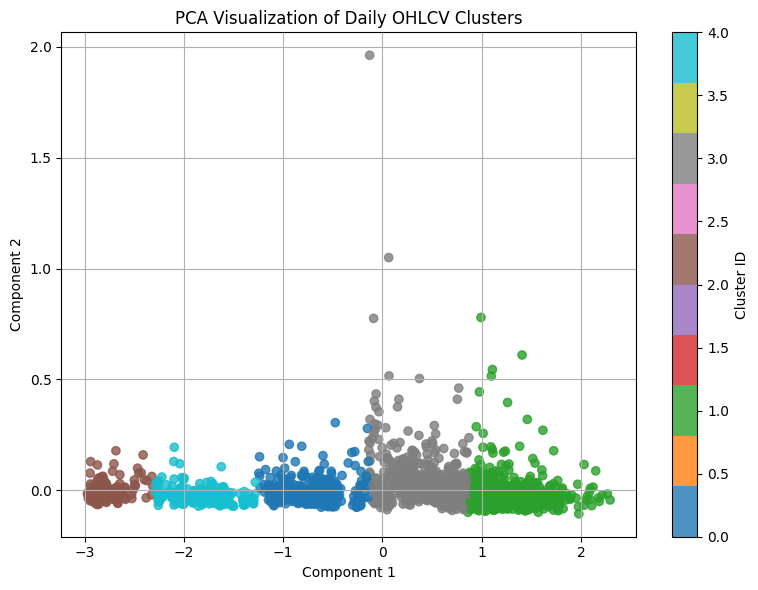

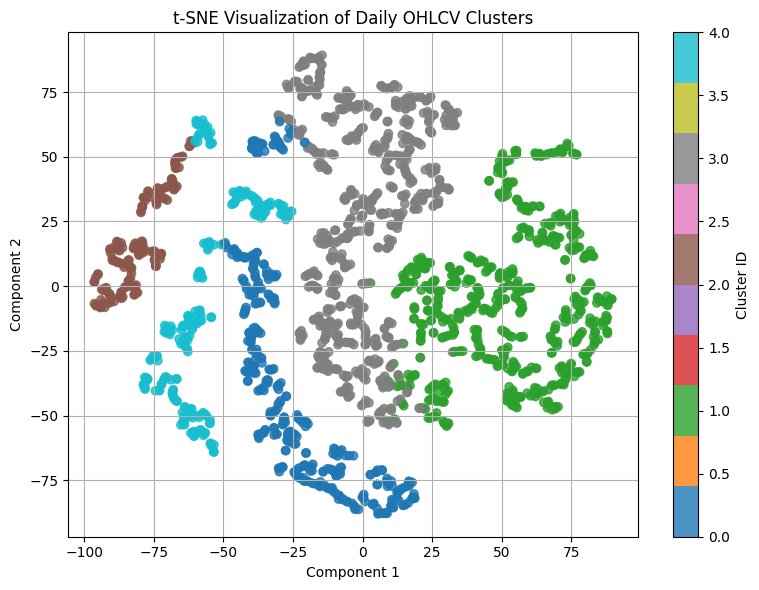

In [48]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# --- Step 1: Flattened & Scaled Sequences from Previous Step ---
# Already available: `flattened_sequences_scaled`, `cluster_labels`, `valid_dates`

# --- Step 2: Reduce to 2D using PCA ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flattened_sequences_scaled)

# --- Step 3: Reduce to 2D using t-SNE ---
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
tsne_result = tsne.fit_transform(flattened_sequences_scaled)

# --- Step 4: Plotting Function ---
def plot_embedding(result, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(result[:, 0], result[:, 1], c=cluster_labels, cmap='tab10', alpha=0.8)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(scatter, label="Cluster ID")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Step 5: Show Both Visuals ---
plot_embedding(pca_result, "PCA Visualization of Daily OHLCV Clusters")
plot_embedding(tsne_result, "t-SNE Visualization of Daily OHLCV Clusters")


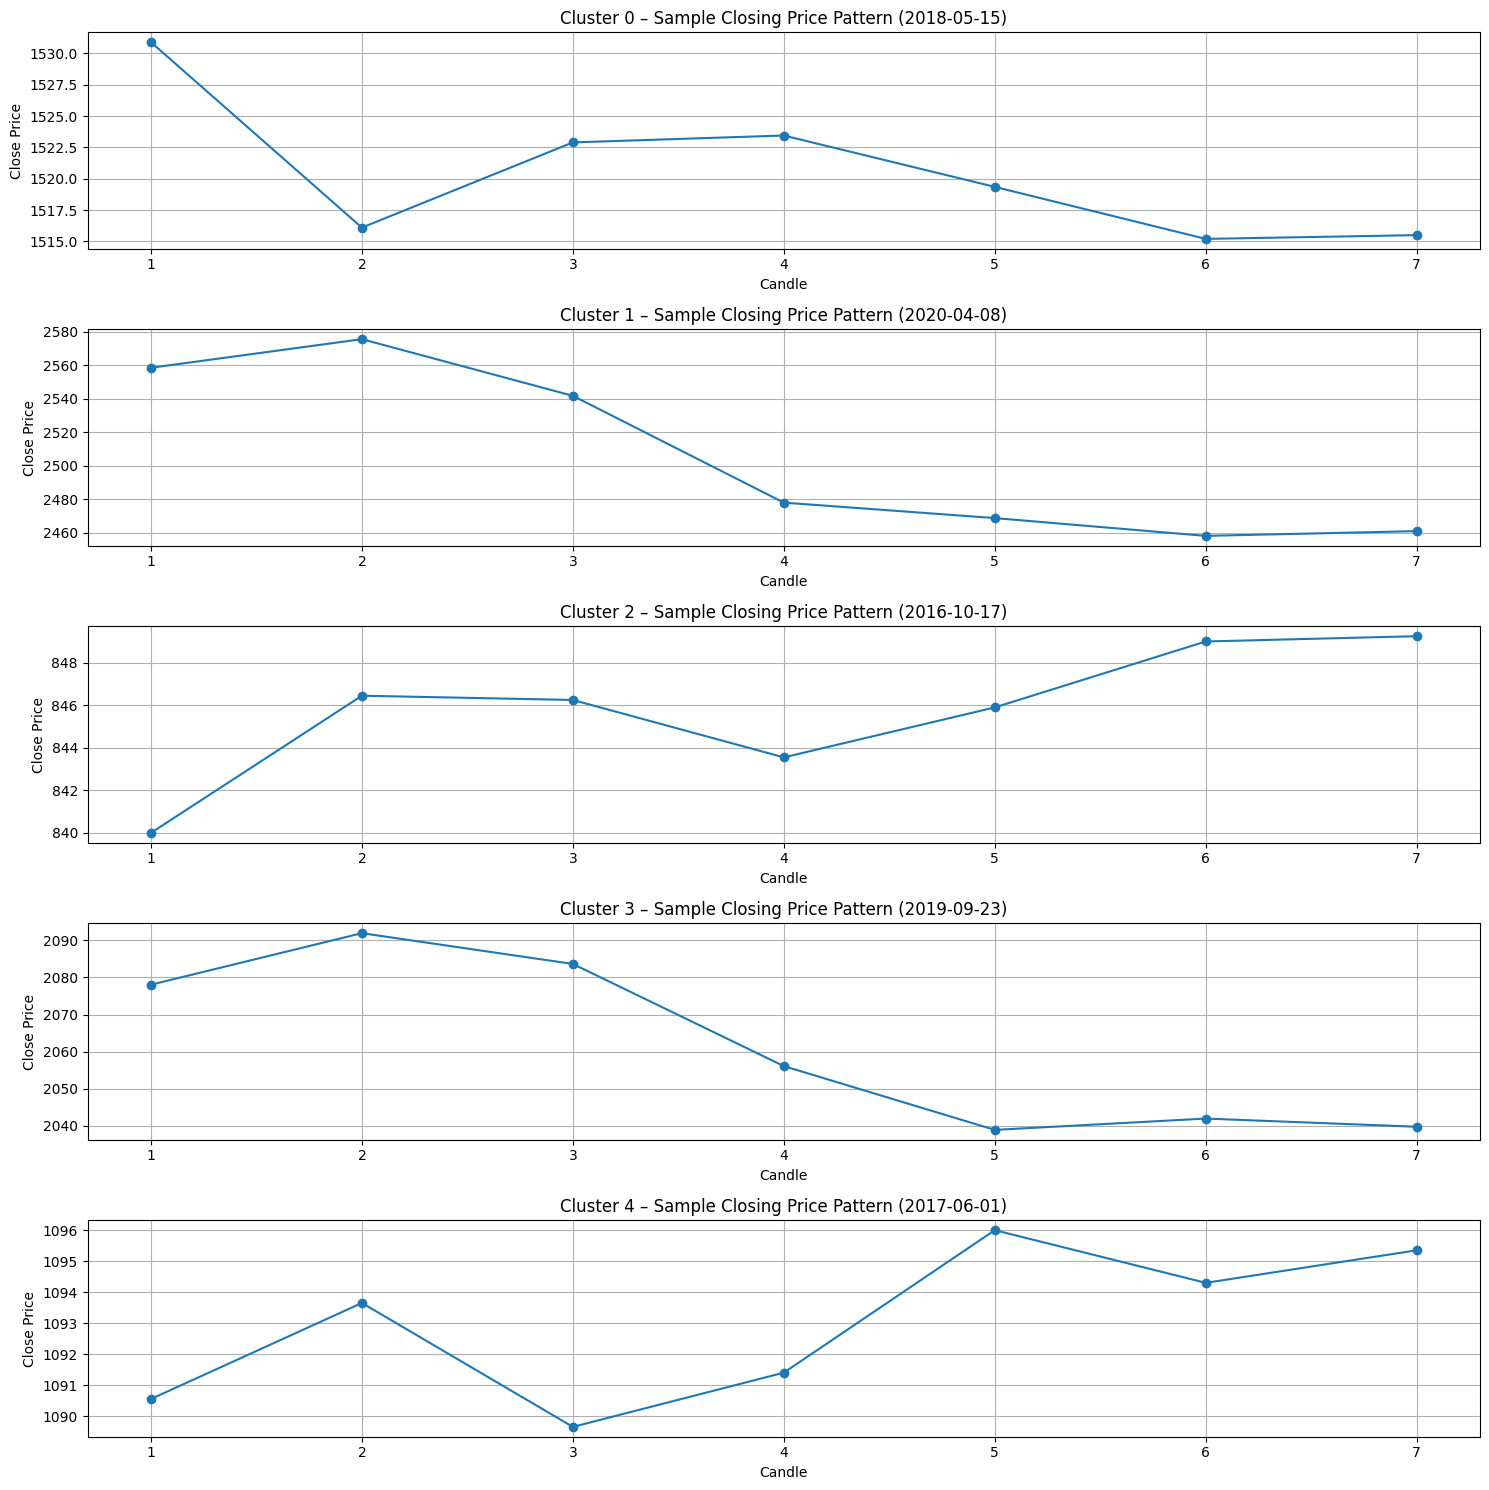

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# --- Plot one sample day from each cluster ---
unique_clusters = np.unique(cluster_labels)

plt.figure(figsize=(15, 3 * len(unique_clusters)))

for i, cluster_id in enumerate(unique_clusters):
    sample_idx = np.where(cluster_labels == cluster_id)[0][0]  # First matching sample
    sample_date = valid_dates[sample_idx]

    # Extract closing price sequence for that day
    day_data = combined_df.loc[str(sample_date)]
    closing_prices = day_data['Close'].values

    # Subplot
    plt.subplot(len(unique_clusters), 1, i + 1)
    plt.plot(range(1, 8), closing_prices, marker='o')
    plt.title(f"Cluster {cluster_id} – Sample Closing Price Pattern ({sample_date})")
    plt.xlabel("Candle")
    plt.ylabel("Close Price")
    plt.grid(True)

plt.tight_layout()
plt.show()



In [54]:
split_date = pd.to_datetime('2025-03-01')
train_df = combined_df[combined_df.index < split_date]
test_df = combined_df[combined_df.index >= split_date]



In [55]:
train_df.tail()

,Open,High,Low,Close,Volume,MA_20,MA_50,RSI_14,Close_Lag_1,Volume_Lag_1,Close_Lag_2,Volume_Lag_2,Close_Lag_3,Volume_Lag_3,VAE_Feature_1,VAE_Feature_2,VAE_Feature_3,VAE_Feature_4,Cluster_ID
DateTime,,,,,,,,,,,,,,,,,,,
2025-02-28 11:15:00,2207.00,2216.50,2203.10,2215.60,254295,2243.4375,2250.614,31.172258,2207.05,334836.0,2205.10,434459.0,2243.55,168631.0,0.001145,0.003971,-0.004006,-0.002471,3.0
2025-02-28 12:15:00,2215.50,2217.00,2202.90,2205.85,190948,2241.5375,2248.341,29.191670,2215.60,254295.0,2207.05,334836.0,2205.10,434459.0,0.001273,0.004145,-0.003960,-0.002359,3.0
2025-02-28 13:15:00,2205.50,2206.95,2193.75,2197.00,257064,2239.3250,2246.314,27.958080,2205.85,190948.0,2215.60,254295.0,2207.05,334836.0,0.001292,0.004026,-0.003907,-0.002414,3.0
2025-02-28 14:15:00,2197.00,2208.35,2187.70,2189.00,1353158,2236.7150,2244.313,26.868096,2197.00,257064.0,2205.85,190948.0,2215.60,254295.0,0.001417,0.003852,-0.003765,-0.002429,3.0
2025-02-28 15:15:00,2189.05,2197.00,2185.85,2196.00,850838,2234.2525,2242.277,31.254040,2189.00,1353158.0,2197.00,257064.0,2205.85,190948.0,0.001078,0.003890,-0.003878,-0.002218,3.0


In [56]:
test_df.head()

,Open,High,Low,Close,Volume,MA_20,MA_50,RSI_14,Close_Lag_1,Volume_Lag_1,Close_Lag_2,Volume_Lag_2,Close_Lag_3,Volume_Lag_3,VAE_Feature_1,VAE_Feature_2,VAE_Feature_3,VAE_Feature_4,Cluster_ID
DateTime,,,,,,,,,,,,,,,,,,,
2025-03-03 09:15:00,2197.00,2199.0,2165.65,2169.20,168941,2230.2750,2239.711,28.516662,2196.00,850838.0,2189.00,1353158.0,2197.00,257064.0,0.001607,0.003781,-0.003610,-0.002733,3.0
2025-03-03 10:15:00,2169.60,2171.9,2158.50,2166.25,181029,2225.3100,2237.502,22.040816,2169.20,168941.0,2196.00,850838.0,2189.00,1353158.0,0.001268,0.003526,-0.003665,-0.002821,3.0
2025-03-03 11:15:00,2166.60,2175.0,2163.90,2174.45,202772,2220.7925,2235.565,27.054046,2166.25,181029.0,2169.20,168941.0,2196.00,850838.0,0.000888,0.003484,-0.003767,-0.002506,3.0
2025-03-03 12:15:00,2174.45,2176.6,2164.90,2173.70,194007,2216.3675,2233.750,29.276538,2174.45,202772.0,2166.25,181029.0,2169.20,168941.0,0.000803,0.003585,-0.003714,-0.002279,3.0
2025-03-03 13:15:00,2173.90,2173.9,2163.55,2168.70,176753,2211.7925,2232.118,20.751988,2173.70,194007.0,2174.45,202772.0,2166.25,181029.0,0.000878,0.003650,-0.003598,-0.002284,3.0


In [60]:
train_df.dropna(inplace=True)

C:\Users\mukesh\AppData\Local\Temp\ipykernel_32196\519058362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.dropna(inplace=True)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 35, 64)            21248     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 7)                 231       
                                                                 
Total params: 33,895
Trainable params: 33,895
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
446/446 [==============================] - 6s 9ms/step - loss: 0.0033
Epoch 2/5
446/446 [==============================] - 4s 9ms/step - loss: 2.1734e-04
Epoch 3/5
446/446 [==============================] - 4s 9ms/step - loss: 2.0688e-04
Epoch 4/5
446/446 [==============================] - 4s 8ms/step -

C:\Users\mukesh\AppData\Local\Temp\ipykernel_32196\3742049753.py:68: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mukesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


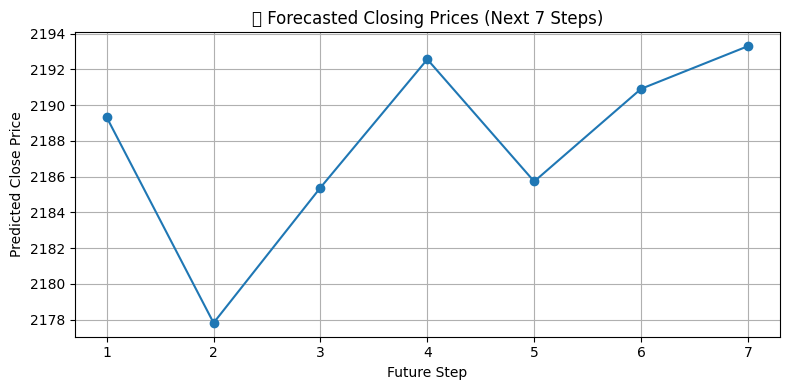

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# --- Step 1: Setup ---
input_seq_len = 35
forecast_steps = 7
target = 'Close'

# --- Step 2: Prepare feature list (exclude target) ---
input_features = [col for col in train_df.columns if col != target]

# --- Step 3: Scale each feature independently ---
scalers = {}
scaled_data = pd.DataFrame(index=train_df.index)

for feature in input_features:
    scaler = MinMaxScaler()
    scaled_data[feature] = scaler.fit_transform(train_df[[feature]])
    scalers[feature] = scaler

# Also scale the target (for training and inverse transform of prediction)
target_scaler = MinMaxScaler()
scaled_data[target] = target_scaler.fit_transform(train_df[[target]])

# --- Step 4: Create sequences ---
def create_sequences(df, input_features, target_col, input_len, forecast_len):
    X, y = [], []
    for i in range(len(df) - input_len - forecast_len + 1):
        input_seq = df[input_features].iloc[i:i+input_len].values
        target_seq = df[target_col].iloc[i+input_len:i+input_len+forecast_len].values
        X.append(input_seq)
        y.append(target_seq)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, input_features, target, input_seq_len, forecast_steps)

# --- Step 5: Build LSTM model ---
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(input_seq_len, len(input_features))),
    LSTM(32),
    Dense(forecast_steps)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Step 6: Train the model ---
model.fit(X, y, epochs=5, batch_size=32, verbose=1)

# --- Step 7: Predict using last available 35 rows ---
last_seq = scaled_data[input_features].iloc[-input_seq_len:].values
last_seq = np.expand_dims(last_seq, axis=0)  # shape: (1, 35, features)

predicted_scaled = model.predict(last_seq)[0]  # shape: (7,)
predicted_close = target_scaler.inverse_transform(predicted_scaled.reshape(-1, 1)).flatten()

# --- Step 8: Plot only forecasted Close prices ---



C:\Users\mukesh\AppData\Local\Temp\ipykernel_32196\2806483240.py:15: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


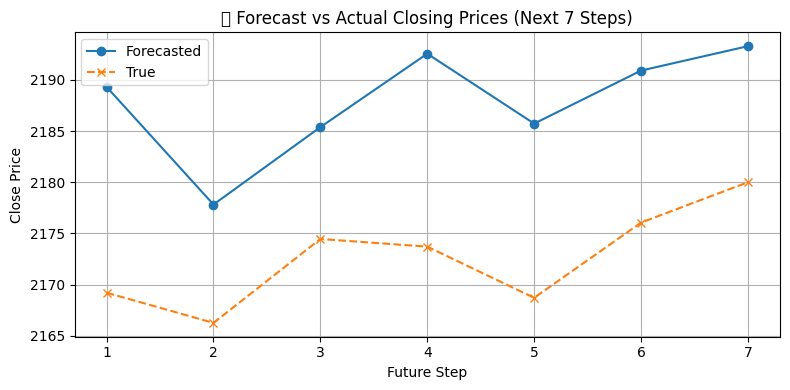

In [65]:
plt.figure(figsize=(8, 4))

# Forecasted Close (steps 1 to 7)
plt.plot(range(1, forecast_steps + 1), predicted_close, marker='o', label='Forecasted')

# True Close from test_df (shifted by 1 step forward)
true_close = test_df['Close'].iloc[:forecast_steps].values
plt.plot(range(1, forecast_steps + 1), true_close, marker='x', linestyle='--', label='True')

plt.title("📈 Forecast vs Actual Closing Prices (Next 7 Steps)")
plt.xlabel("Future Step")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
